I have used Two datasets - Rodrigo dataset and a synthetic dataset generated using VRD generator 

Rodrigo dataset


In [1]:
import pandas as pd

def load_image_paths(file_path):
    """Load image paths from a txt file."""
    with open(file_path, "r") as f:
        return [line.strip() for line in f.readlines()]

def load_transcriptions(transcription_file):
    """Load transcriptions from the transcription txt file and return a dictionary mapping image paths to transcriptions."""
    transcription_dict = {}
    with open(transcription_file, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split(" ", 1)  # Split into image path and transcription
            if len(parts) == 2:
                image_path, transcription = parts
                transcription_dict[image_path] = transcription
    return transcription_dict

def create_dataframe(image_paths, transcription_dict):
    """Create a DataFrame with image paths and their transcriptions."""
    data = {"image_path": image_paths, "transcription": [transcription_dict.get(img, "") for img in image_paths]}
    return pd.DataFrame(data)

# File paths
train_txt = "/teamspace/studios/this_studio/train.txt"
val_txt = "/teamspace/studios/this_studio/validation.txt"
test_txt = "/teamspace/studios/this_studio/test.txt"
transcription_txt = "/teamspace/studios/this_studio/transcriptions.txt"

# Load data
train_paths = load_image_paths(train_txt)
val_paths = load_image_paths(val_txt)
test_paths = load_image_paths(test_txt)
transcriptions = load_transcriptions(transcription_txt)

# Create DataFrames
df_train = create_dataframe(train_paths, transcriptions)
df_val = create_dataframe(val_paths, transcriptions)
df_test = create_dataframe(test_paths, transcriptions)
df_train = pd.concat([df_train , df_test] , ignore_index = True)


In [2]:
df_train.head()

,image_path,transcription
0,Rodrigo_00006_00,Historia De España_Del
1,Rodrigo_00006_01,Arçobispo. Do Rodri_
2,Rodrigo_00006_02,go. Traducida En Ro_
3,Rodrigo_00006_03,mançe
4,Rodrigo_00008_00,E ste es el libro de la Cronica de es


In [3]:
len(df_train)

14010

In [4]:
len(df_val)

1000

VRD dataset

In [5]:
df_vrd = pd.read_csv('/teamspace/studios/this_studio/GEN_IMAGES_DF.csv')

In [6]:
df_vrd.head()

,Unnamed: 0,path,text
0,0,image_5_1.png,Nunca ofendí la fe con la esperanza;
1,1,image_0_1.png,"Valencia insigne, patria venturosa,"
2,2,image_12_1.png,"Clarín, que rosicleres troglodita,"
3,3,image_11_1.png,"Tiemble la tierra, y con furor horrendo"
4,4,image_3_1.png,"De tu muerte que fue un breve suspiro,"


In [7]:
df_vrd = df_vrd.drop(columns = ['Unnamed: 0'])
df_vrd = df_vrd.rename(columns={'path': 'image_path' , 'text' : 'transcription'})


In [8]:
df_vrd.head()

,image_path,transcription
0,image_5_1.png,Nunca ofendí la fe con la esperanza;
1,image_0_1.png,"Valencia insigne, patria venturosa,"
2,image_12_1.png,"Clarín, que rosicleres troglodita,"
3,image_11_1.png,"Tiemble la tierra, y con furor horrendo"
4,image_3_1.png,"De tu muerte que fue un breve suspiro,"


In [9]:
len(df_vrd)

15368

In [10]:
df_vrd_val = df_vrd.sample(frac = 0.05 , random_state = 42)
df_vrd_train = df_vrd.drop(df_vrd_val.index)

In [11]:
len(df_vrd_val)

768

In [12]:
df_val_final = pd.concat([df_val ,df_vrd_val] , ignore_index = True ).sample(frac=1, random_state=42).reset_index(drop=True)
df_train_final = pd.concat([df_train , df_vrd_train] , ignore_index = True).sample(frac=1, random_state=42).reset_index(drop=True)

final Dataframes

In [13]:
len(df_train_final)

28610

In [14]:
df_train_final.head()

,image_path,transcription
0,Rodrigo_00491_11,doña vrraca e doña Eluira. E porque doña vrrac...
1,Rodrigo_00189_21,aqui sino A morir mala muerte. tornad vos para...
2,Rodrigo_00182_01,astraguemos e pues no son nrōs yguales en Arma...
3,Rodrigo_00536_01,"cho. E veyendo los condes qe el rei, lo vno co..."
4,image_270_1.png,"Ya Flori sale el campo, todo es flores,"


In [15]:
len(df_val_final)

1768

In [16]:
df_val_final.head()

,image_path,transcription
0,Rodrigo_00407_06,ouo al ynfante don Ordoño y de la otra ouo a l...
1,Rodrigo_00121_16,es Verdadera creencia y verdadera Regla de chr...
2,Rodrigo_00180_13,67 ¶ Agora cuenta la historia de
3,Rodrigo_00399_12,don Ermigio obispo de tui e martiriaronlo En c...
4,Rodrigo_00217_07,la espina de la sebe qe se mette por el pie o ...


correcting the nuances of 17th century spanish

In [17]:
import re
import spacy

# Load spaCy's Spanish language model
nlp = spacy.load("es_core_news_md")

def is_valid_spanish_word(word):
    """Check if a word exists in modern Spanish using spaCy."""
    lexeme = nlp.vocab[word]
    return lexeme.is_oov == False  # If False, the word is in the vocabulary

def modify_u_v(word):
    """Try replacing 'v' with 'u' or vice versa and check if the word exists in Spanish."""
    if is_valid_spanish_word(word):
        return word  # If the word is already valid, return as is

    # Try replacing 'v' with 'u' and check again
    modified_word = word.replace('v', 'u').replace('V' , 'U')
    if is_valid_spanish_word(modified_word):
        return modified_word

    # Try replacing 'u' with 'v' and check again
    modified_word = word.replace('u', 'v').replace('U' , 'V')
    if is_valid_spanish_word(modified_word):
        return modified_word

    return word  # If no valid modification, return original word

def preprocess_text(text):
    # Normalize 'ſ' (long s) to 's'
    text = text.replace('ſ', 's')

    # Tokenize text into words
    words = text.split()

    # Modify 'u' and 'v' based on dictionary lookup
    processed_words = [modify_u_v(word) for word in words]

    # Reconstruct text
    text = ' '.join(processed_words)

    # Remove accents except for 'ñ'
    text = re.sub(r'(?<!ñ)[áàâä]', 'a', text)
    text = re.sub(r'(?<!ñ)[éèêë]', 'e', text)
    text = re.sub(r'(?<!ñ)[íìîï]', 'i', text)
    text = re.sub(r'(?<!ñ)[óòôö]', 'o', text)
    text = re.sub(r'(?<!ñ)[úùûü]', 'u', text)

    # Replace macrons with appropriate expansion
    text = re.sub(r'([aeiou])̄', r'\1n', text)  # Replace vowels with macrons with 'n'
    text = re.sub(r'q̄', 'que', text)  # Replace 'q̄' with 'que'

    # Leave split words as is
    text = text.replace('-\n', '\n')

    # Replace 'ç' with 'z'
    text = text.replace('ç', 'z')

    return text


In [19]:
preprocess_text('doña vrraca e doña Eluira. E porque doña vrraca era sa')

'doña urraca e doña Eluira. E porque doña urraca era sa'

In [21]:
df_train_final['transcription'] = df_train_final['transcription'].apply(preprocess_text)
df_val_final['transcription'] = df_val_final['transcription'].apply(preprocess_text)

In [22]:
df_train_final.iloc[0]['transcription']

'doña urraca e doña Eluira. E porque doña urraca era sa'

In [24]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import os

def preprocess_image(image):
    """Prepares image by applying adaptive thresholding, noise removal, and inversion."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    

    # Adaptive Thresholding
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                   cv2.THRESH_BINARY_INV, 5, 5)
    # _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask to filter out small components
    mask = np.zeros_like(binary)

    # Keep only larger contours
    for cnt in contours:
        if cv2.contourArea(cnt) > 5:  # Adjust threshold based on noise size
            cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)

    # Apply mask to original image
    binary = cv2.bitwise_and(binary, mask)                               

    # Remove small noise using connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary , connectivity=8)
    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < 5:  # Threshold for noise removal
            binary[labels == i] = 0

    # Invert image
    processed = cv2.bitwise_not(binary)

    return processed

def remove_borders(image):
    """Removes borders from scanned documents using edge and line detection."""
    if len(image.shape) == 3:  # Check if image has color channels
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)[1]

    # Detect horizontal and vertical lines
    kernel_h = np.ones((1, 50), np.uint8)
    kernel_v = np.ones((50, 1), np.uint8)

    horizontal_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_h)
    vertical_lines = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_v)

    # Combine detected lines
    lines = cv2.addWeighted(horizontal_lines, 0.5, vertical_lines, 0.5, 0)

    # Detect strong lines using Hough Transform
    edges = cv2.Canny(lines, 50, 150, apertureSize=3)
    lines_detected = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=200, maxLineGap=5)

    mask = np.ones_like(binary) * 255  # White background
    if lines_detected is not None:
        for line in lines_detected:
            x1, y1, x2, y2 = line[0]
            cv2.line(mask, (x1, y1), (x2, y2), 0, 3)  # Draw detected lines in black

    # Dilate and subtract the mask from the original image
    mask = cv2.dilate(mask, np.ones((5, 5), np.uint8), iterations=2)
    result = cv2.bitwise_and(image, image, mask=mask)

    return result

def enhance_sharpness(image):
    """Enhances the sharpness of the image using PIL."""
    pil_image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    enhancer = ImageEnhance.Sharpness(pil_image)
    enhanced_image = enhancer.enhance(2)  # Increase sharpness factor
    return cv2.cvtColor(np.array(enhanced_image), cv2.COLOR_RGB2BGR)


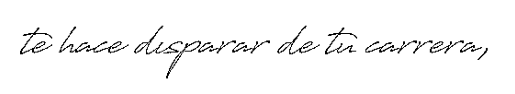

In [25]:
import matplotlib.pyplot as plt
img_path = '/teamspace/studios/this_studio/GEN_IMAGES/image_1_2.png'
image = cv2.imread(img_path)
preprocessed = preprocess_image(image)
# borderless = remove_borders(preprocessed)
sharpened_img = enhance_sharpness(preprocessed)
plt.imshow(sharpened_img, cmap='gray')
plt.axis('off')
plt.show()

In [26]:
image.shape

(81, 540, 3)

In [27]:
from transformers import TrOCRProcessor, AutoTokenizer, VisionEncoderDecoderModel
processor = TrOCRProcessor.from_pretrained("qantev/trocr-base-spanish" , use_fast = True)
model = VisionEncoderDecoderModel.from_pretrained("qantev/trocr-base-spanish")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decode

In [28]:
processor.tokenizer.vocab_size

50265

In [29]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                            Param #
VisionEncoderDecoderModel                                         --
├─ViTModel: 1-1                                                   --
│    └─ViTEmbeddings: 2-1                                         443,904
│    │    └─ViTPatchEmbeddings: 3-1                               590,592
│    │    └─Dropout: 3-2                                          --
│    └─ViTEncoder: 2-2                                            --
│    │    └─ModuleList: 3-3                                       85,026,816
│    └─LayerNorm: 2-3                                             1,536
│    └─ViTPooler: 2-4                                             --
│    │    └─Linear: 3-4                                           590,592
│    │    └─Tanh: 3-5                                             --
├─TrOCRForCausalLM: 1-2                                           --
│    └─TrOCRDecoderWrapper: 2-5                                   --
│  

In [30]:
processor

TrOCRProcessor:
- image_processor: ViTImageProcessorFast {
  "crop_size": null,
  "default_to_square": true,
  "do_center_crop": null,
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "TrOCRProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: RobertaTokenizerFast(name_or_path='qantev/trocr-base-spanish', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, n

In [31]:
processor.tokenizer.pad_token_id

1

Already configured acc to the tokenizer

In [ ]:
from peft import LoraConfig, get_peft_model
config = LoraConfig(
    r=16,  # Rank (adjust as needed)
    lora_alpha=16,  # Scaling factor
    lora_dropout=0.1,  # Dropout for LoRA layers
    target_modules=[
        "query" , "value" , "q_proj" , "v_proj"
    ]
)
# Apply LoRA
model = get_peft_model(model, config)

In [34]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                                      Param #
PeftModel                                                                   --
├─LoraModel: 1-1                                                            --
│    └─VisionEncoderDecoderModel: 2-1                                       --
│    │    └─ViTModel: 3-1                                                   87,833,088
│    │    └─TrOCRForCausalLM: 3-2                                           301,258,752
Total params: 389,091,840
Trainable params: 4,227,072
Non-trainable params: 384,864,768

In [35]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"Trainable Parameters: {trainable_params}/{total_params} ({100 * trainable_params/total_params:.2f}%)")


Trainable Parameters: 4227072/389091840 (1.09%)


In [36]:
import torch.nn as nn
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.decoder.config.vocab_size = processor.tokenizer.vocab_size
model.config.vocab_size = model.decoder.config.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id

In [37]:
from transformers import GenerationConfig

# Define a generation configuration
gen_config = GenerationConfig(
    max_length=64,
    early_stopping=True,
    no_repeat_ngram_size=3,
    length_penalty=2.0,
    num_beams=4
)


In [38]:
def preprocessing(img_path):
  image = cv2.imread(img_path)
  preprocessed = preprocess_image(image)
  # borderless = remove_borders(preprocessed)
  sharpened_img = enhance_sharpness(preprocessed)
  pixel_values = processor(sharpened_img, return_tensors="pt").pixel_values.squeeze()
  return pixel_values

In [39]:
preprocessing(img_path).shape

torch.Size([3, 384, 384])

In [41]:
from torch.utils.data import DataLoader , Dataset
from torch.nn.utils.rnn import pad_sequence
import torch
class SpanishDocumentsDataset(Dataset):
    def __init__(self, df , processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image_path = self.df.iloc[idx]['image_path']
            if image_path[0] == "R":
                image_path = os.path.join( '/teamspace/studios/this_studio/images', image_path) + '.png'
            else:
                image_path = os.path.join( '/teamspace/studios/this_studio/GEN_IMAGES', image_path) 
            pixel_values = preprocessing(image_path)
            text = self.df.iloc[idx]['transcription']
            labels = self.processor.tokenizer(text, return_tensors="pt").input_ids.squeeze()
            # labels[labels == self.processor.tokenizer.pad_token_id] = -100
            return {"pixel_values": pixel_values, "labels": labels}
        except Exception as e:
            raise Exception(f"Failed to load data for index {idx}: {e}")

In [42]:
def custom_collate_fn(batch):
    try:
        pixel_values = [item['pixel_values'] for item in batch]
        labels = [item['labels'] for item in batch]
        labels = pad_sequence(labels, batch_first=True, padding_value= processor.tokenizer.pad_token_id)
        pixel_values = torch.stack(pixel_values)
        return {"pixel_values": pixel_values, "labels": labels}
    except Exception as e:
        raise Exception(f"Failed to collate batch: {e}")

In [43]:
train_dataset = SpanishDocumentsDataset(df_train_final, processor)
val_dataset = SpanishDocumentsDataset(df_val_final, processor)

In [33]:
# Dummy image input
pixel_values = torch.rand(1, 3, 384, 384)  # Batch size 1, RGB image

# Generate decoder inputs (empty start token)
decoder_input_ids = torch.tensor([[model.config.decoder_start_token_id]])

# Forward pass
outputs = model(pixel_values=pixel_values, decoder_input_ids=decoder_input_ids)

# Logits
print(outputs.logits.shape)

torch.Size([1, 1, 50262])


In [44]:
b_size = 32

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=b_size, shuffle=True, collate_fn=custom_collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=b_size, shuffle=False, collate_fn=custom_collate_fn)
# test_dataloader = DataLoader(test_dataset, batch_size=b_size, shuffle=False, collate_fn=custom_collate_fn)

In [46]:
for batch in train_dataloader:
    print(batch)
    break

{'pixel_values': tensor([[[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000]],

         [[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1

In [ ]:
from datasets import load
import evaluate
# from nltk.translate.bleu_score import sentence_bleu

cer_metric = evaluate.load("cer")
wer_metric = evaluate.load("wer")
bleu = evaluate.load("sacrebleu")


def compute_metrics(eval_pred):
    try:
        # Compute Character Error Rate (CER) and Word Error Rate (WER)
        decoded_preds , decoded_labels = eval_pred
        cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
        wer = wer_metric.compute(predictions=decoded_preds, references=decoded_preds)

        # Compute BLEU Score
        bleu_score = bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels], smooth_method="exp")

        return {
            "cer": cer,
            "wer": wer,
            "Bleu": bleu_score['score'],
        }

    except Exception as e:
        raise Exception(f"Failed to compute metrics: {e}")


In [46]:
len(train_dataloader)

895

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import VisionEncoderDecoderModel
from tqdm import tqdm
import random


# Training and evaluation function
def train_model(model, train_dataloader, val_dataloader, optimizer, device,scheduler, epochs=5, grad_accum_steps=1):
    
    train_l = []
    eval_l = []
    wer = []
    cer = []
    bleu = []
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training
        model.train()
        total_loss = 0.0

        optimizer.zero_grad()
        progress_bar = tqdm(train_dataloader, desc="Training", leave=False)

        for step, batch in enumerate(progress_bar):  # Use the same tqdm instance
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["labels"][:, :-1].to(device).contiguous()
            labels = batch["labels"][:, 1:].to(device).contiguous()

            outputs = model(pixel_values=pixel_values, decoder_input_ids=input_ids).logits
            loss_fn = torch.nn.CrossEntropyLoss(ignore_index=processor.tokenizer.pad_token_id)
            loss = loss_fn(outputs.view(-1, outputs.size(-1)), labels.view(-1))
            loss /= grad_accum_steps  # Normalize loss for gradient accumulation

            loss.backward()
            total_loss += loss.item() * grad_accum_steps
            train_l.append(loss.item() * grad_accum_steps)

            if (step + 1) % grad_accum_steps == 0:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            # Dynamically update loss in tqdm progress bar
            progress_bar.set_postfix(loss=f"{loss.item() * grad_accum_steps:.4f}")
        train_loss =  total_loss / len(train_dataloader)
        
        print(f"Training Loss: {train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        wer_v = 0
        cer_v = 0
        bleu_v = 0
        predictions, references = [], []
        with torch.no_grad():
            progress_bar = tqdm(val_dataloader, desc="Evaluating", leave=False)

            for batch in progress_bar :
                pixel_values = batch["pixel_values"].to(device)
                input_ids = batch["labels"][:,:-1].to(device).contiguous()
                labels = batch["labels"][:,1:].to(device).contiguous()

                outputs = model(pixel_values=pixel_values, decoder_input_ids=input_ids).logits
                # outputs = torch.argmax(outputs , dim = -1).squeeze()
                loss_fn = torch.nn.CrossEntropyLoss(ignore_index = processor.tokenizer.pad_token_id)
                loss = loss_fn(outputs.view(-1,outputs.size(-1)) , labels.view(-1))
                loss /= grad_accum_steps
                outputs_g = model.generate(pixel_values=pixel_values, generation_config=gen_config)
                decoded_preds = processor.tokenizer.batch_decode(outputs_g, skip_special_tokens=True)
                decoded_labels = processor.tokenizer.batch_decode(labels, skip_special_tokens=True)

                metric = compute_metrics((decoded_preds , decoded_labels))

                predictions.extend(decoded_preds)
                references.extend(decoded_labels)
                wer.append(metric['wer'])
                cer.append(metric['cer'])
                bleu.append(metric['Bleu'])
                val_loss += loss.item() * grad_accum_steps
                wer_v +=metric['wer']
                cer_v += metric['cer']
                bleu_v += metric['Bleu']
                eval_l.append(loss.item() * grad_accum_steps)
                progress_bar.set_postfix(val_loss=loss.item() * grad_accum_steps , wer = metric['wer'] , cer = metric['cer'] , bleu = metric['Bleu'] )

            val_loss =  val_loss / len(val_dataloader)
            wer_v /= len(val_dataloader)
            cer_v /= len(val_dataloader)
            bleu_v /= len(val_dataloader)
        
        

        print(f"val Loss: {val_loss:.4f} , wer : {wer_v:.4f} , cer : {cer_v:.4f} , bleu_score : {bleu_v:.4f} ")

        # Print sample predictions
        # Ensure there are at least three samples
        num_samples = min(3, len(decoded_preds))

        # Select three random indices
        random_indices = random.sample(range(len(decoded_preds)), num_samples)

        # Print the selected samples
        for i in random_indices:
            print(f"Pred: {decoded_preds[i]}")
            print(f"Ref: {decoded_labels[i]}\n")

        # Save model checkpoint
        save_path = f"/teamspace/studios/this_studio/2nd_qantev_model"
        os.makedirs(save_path, exist_ok=True)  # Ensure directory exists

        # Save only model weights
        torch.save(model.state_dict(), os.path.join(save_path, f"model_checkpoint_epoch_{epoch+1}.pth"))

    return train_l , eval_l , wer , cer , bleu 


In [48]:
# Initialize model, optimizer, and dataloaders
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_new = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, 
    T_0=1,  # Number of epochs before the first restart
    T_mult=2,  # Multiplicative factor for the restart period
    eta_min=1e-6  # Minimum learning rate
)


In [49]:
# Assuming train_dataloader and val_dataloader are already created
train_l , eval_l , wer , cer , bleu = train_model(model, train_dataloader, val_dataloader, optimizer, device,scheduler, epochs=10, grad_accum_steps=4)


Epoch 1/10


Training Loss: 1.2957


val Loss: 0.7138 , wer : 0.0000 , cer : 0.0996 , bleu_score : 54.1187 
Pred: Taz, las brabras y aunque alimentura,
Ref: Trago las brasas, y aunque alla sintieron

Pred: y el planeta, que nunca para, dora
Ref: y el planeta, que nunca para, dora

Pred: ¡Al miño de amor fiestas celebra,
Ref: Al milagro de amor fiestas celebra,


Epoch 2/10


Training Loss: 0.7375


val Loss: 0.5700 , wer : 0.0000 , cer : 0.0736 , bleu_score : 63.3751 
Pred: Al mismo de amor, fiestas celebra,
Ref: Al milagro de amor fiestas celebra,

Pred: y el planeta, que nunca para, dora
Ref: y el planeta, que nunca para, dora

Pred: y de las ondas se escapo el piloto,
Ref: y de las ondas se escapo el piloto,


Epoch 3/10


Training Loss: 0.6020


val Loss: 0.5141 , wer : 0.0000 , cer : 0.0662 , bleu_score : 66.5271 
Pred: y el planeta, que nunca para, dora
Ref: y el planeta, que nunca para, dora

Pred: Al mirio de amor, fiestas celebra,
Ref: Al milagro de amor fiestas celebra,

Pred: Juez fue home muy paciente e sabidor y entendi
Ref: Juez fue home muy paciente e sabidor y entendi


Epoch 4/10


Training Loss: 0.5014


val Loss: 0.4562 , wer : 0.0000 , cer : 0.0579 , bleu_score : 70.0939 
Pred: y de las ondas se escapo el piloto,
Ref: y de las ondas se escapo el piloto,

Pred: pues tambien veene a ser aplraso tego,
Ref: pues tambien viene a ser aplauso tuyo.

Pred: Al mirio de amor, fiestas celebra,
Ref: Al milagro de amor fiestas celebra,


Epoch 5/10


Training Loss: 0.4588


val Loss: 0.4737 , wer : 0.0000 , cer : 0.0610 , bleu_score : 68.9387 
Pred: y si es de noche, luego nace el dia
Ref: y si es de noche, luego nace el dia;

Pred: de dos soles que en gloria juzgo iguales
Ref: de dos soles que en gloria juzgo iguales,

Pred: Juez fue home muy paciente e sabidor y entendi
Ref: Juez fue home muy paciente e sabidor y entendi


Epoch 6/10


Training Loss: 0.4616


val Loss: 0.4349 , wer : 0.0000 , cer : 0.0574 , bleu_score : 71.1043 
Pred: y si es de noche, luego nace el dia,
Ref: y si es de noche, luego nace el dia;

Pred: Taga, las bienes y amor, alli sintiene,
Ref: Trago las brasas, y aunque alla sintieron

Pred: pues tambien viene a ser aplraso tego,
Ref: pues tambien viene a ser aplauso tuyo.


Epoch 7/10


Training Loss: 0.3969


val Loss: 0.4026 , wer : 0.0000 , cer : 0.0515 , bleu_score : 73.3556 
Pred: y el planeta, que nunca para, dora
Ref: y el planeta, que nunca para, dora

Pred: y de las ondas se escapo el piloto,
Ref: y de las ondas se escapo el piloto,

Pred: de dos soles que en gloria fuzgo iguales
Ref: de dos soles que en gloria juzgo iguales,


Epoch 8/10


Training Loss: 0.3389


val Loss: 0.3842 , wer : 0.0000 , cer : 0.0487 , bleu_score : 74.1700 
Pred: y el planeta, que nunca para, dora
Ref: y el planeta, que nunca para, dora

Pred: Al mirio de amor, fiestas celebra,
Ref: Al milagro de amor fiestas celebra,

Pred: y si es de noche, luego nace el dia,
Ref: y si es de noche, luego nace el dia;


Epoch 9/10


Training Loss: 0.3085


val Loss: 0.3782 , wer : 0.0000 , cer : 0.0478 , bleu_score : 74.8427 
Pred: pues tambien veene a ser aplraso tego,
Ref: pues tambien viene a ser aplauso tuyo.

Pred: de dos soles que en gloria fuzgo iguales
Ref: de dos soles que en gloria juzgo iguales,

Pred: y de las ondas se escapo el piloto,
Ref: y de las ondas se escapo el piloto,


Epoch 10/10


Training Loss: 0.3674


val Loss: 0.4210 , wer : 0.0000 , cer : 0.0544 , bleu_score : 71.8305 
Pred: y le las ondas se escapo el piloto,
Ref: y de las ondas se escapo el piloto,

Pred: de dos soles que en gloria juzgo iguales
Ref: de dos soles que en gloria juzgo iguales,

Pred: Al mirio de amor, fiestas celebra,
Ref: Al milagro de amor fiestas celebra,

